# Scraping CoinMarketCap to produce a crypto portfolio valuation

## Section 1. Overview and project scope

[Coinmarketcap](https://coinmarketcap.com/) is a website that provides real-time data on [cryptocurrencies](https://en.wikipedia.org/wiki/Cryptocurrency). The scope of this project is to leverage Python to:

1. retrieve real-time crypto currency prices from [Coinmarketcap](https://coinmarketcap.com)
2. retrieve real-time foreign exchange rates from [Google Finance](https://www.google.com/finance/)
3. add struture to the retrieved data by creating custom Classes  
4. allow the user to select a portfolio of cryptocurrencies and holdings
5. calculate a real-time portfolio valuation based on the user selection
6. present the portfolio valuation in a professional psql-esque tabular format
7. automate using CRON to run a report each day at 12:20 and write to a log file

## Section 2. Import the required libraries

In [1]:
import requests as r
import re
from bs4 import BeautifulSoup
from dataclasses import dataclass
from typing import List
import datetime as dt
from tabulate import tabulate

In [2]:
now = dt.datetime.now()
hour = now.hour
minute = now.minute 

## Section 3. Retrieving real time data 

A modern dynamic web page generally comprises of a combination of [HTML (Hypertext Markup Lanaguage)](https://en.wikipedia.org/wiki/HTML), [CSS (Cascading Style Sheets)](https://en.wikipedia.org/wiki/CSS) and [JS (JavaScript)](https://simple.wikipedia.org/wiki/JavaScript). We can navigate this complex structure by leveraging the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Requests](https://requests.readthedocs.io/en/latest/) Python libraries.

Let's illustrate how we can obtain real-time forex rates from Google Finance in just a few lines of code.

### Section 3.1 Forex rates

In [3]:
# Custom function to parse exchange rate
def exchange_from_dollar(target_currency):
    
    fx_url = f"https://www.google.com/finance/quote/USD-{target_currency}"
    resp = r.get(fx_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    fx_rate = soup.find("div", attrs={"data-last-price": True})
    fx = float(fx_rate["data-last-price"])
    
    return fx

exchange_from_dollar("GBP") #specify currency to convert from USD

0.821814237

This rate is in line with the `USD:GBP` rate at the time of writing.

### Section 3.2 Crypto prices

We can obtain real-time cryto prices from Coinmarketcap in a similar way.

In [4]:
# Parse the crypto price data
def get_price_info(coin_symbol, target_currency):
    
    fx = exchange_from_dollar(target_currency)
    url = f"https://coinmarketcap.com/currencies/{coin_symbol}/"
    resp = r.get(url)
    soup = BeautifulSoup(resp.content, "html.parser")

    # Locate the span using the `data-test` attribute
    price_span = soup.find("span", {"data-test": "text-cdp-price-display"})
    price_dollars = price_span.text.strip()
    usd_price = float(re.sub("[^0-9.]", "", price_dollars))
    target_currency_price = round(usd_price * fx, 3)
          
    return {
        "coin_symbol": coin_symbol,
        "usd_price": usd_price,
        "target_currency": target_currency,
        "target_currency_price": target_currency_price        
    }

btc_price = get_price_info("bitcoin", "GBP") # *** AMEND THIS AS REQUIRED ***

print(
    f"The value of one unit of {btc_price['coin_symbol']} at {hour}:{minute} on {now:%A}, {now:%d-%m-%Y} in {btc_price['target_currency']} "
    f"is {btc_price['target_currency_price']:,.2f}."
)

The value of one unit of bitcoin at 22:43 on Friday, 17-01-2025 in GBP is 86,084.44.


Wow, where is that old laptop ... !

OK, so this seems to be working well, but is somewhat limited at the moment. Let's scale things up to allow for a portfolio of currencies and holdings, amd add some structure to our data.

### Section 4. Adding Structure with Dataclasses

It would be helpful if we could structure and store our data relating to particular stocks and holdings in a container for easy access. We can leverage the Python [Dataclasses module](https://docs.python.org/3/library/dataclasses.html) to achieve this.  Let's illustrate by creating a custom `Coin` Class.

In [5]:
@dataclass
class Coin:
    coin_symbol: str
    #price: float = 0  # default values
    target_currency: str = "GBP" # *** AMEND THIS AS REQUIRED ***
    usd_price: float = 0  # default values
    target_currency_price: float = 0

    # After initiation, prices from Google kick in
    def __post_init__(self):  # self points to the object of type Coin
        price_info = get_price_info(self.coin_symbol, self.target_currency)

        # Only if logic is true, otherwise proceed with default values
        if price_info["coin_symbol"] == self.coin_symbol:
            self.usd_price = price_info["usd_price"]
            self.target_currency_price = price_info["target_currency_price"]

Given that our aim is ultimately to value a portfolio of crypto coin holdings, next we will create a `Position` Class to store the stock holdings.

In [6]:
@dataclass
class Position:
    coin: Coin # as previously defined
    quantity: float

Finally, let's create a further Class called `Portfolio`.

In [7]:
@dataclass
class Portfolio:
    positions: List[Position]

    def get_total_value(self):
        total_value = 0

        for position in self.positions:
            
            total_value += position.quantity * position.coin.target_currency_price
            
        return total_value

Now let's create an arbitrary user selection portfolio and perform a sanity check on the calculated market value. Let's look at the top 3 coins at the time of writing.

- Bitcoin £85,999
- Ethereum £2,882
- XRP - £3

Almost £89k. Let's check our calculation.

In [8]:
if __name__ == "__main__":

    # Arbitrary user selected portfolio - *** AMEND AS REQUIRED ***
    bitcoin = Coin("bitcoin", "GBP") 
    ethereum  = Coin("ethereum", "GBP") 
    xrp = Coin("xrp", "GBP") 
    
    portfolio = Portfolio([Position(bitcoin, 1), Position(ethereum, 1), Position(xrp,1)])  
    portfolio_value = portfolio.get_total_value()
          
    print(f"The total value of your portfolio at {hour}:{minute} on {now:%A}, {now:%d-%m-%Y} is {Coin.target_currency} {portfolio_value:,.2f}.")

The total value of your portfolio at 22:43 on Friday, 17-01-2025 is GBP 88,948.56.


Excellent, that's in line - prices are extremely volatile. So, that's us done in terms of scraping the data, and creating custom classes to store our data. The final step is to present the data in a more aesthetic way.

### Section 5. Tabular Display

[python-tabulate](https://pypi.org/project/tabulate/)

Pretty-print tabular data in Python, a library and a command-line utility.

The main use cases of the library are: 

- printing small tables without hassle: just one function call, formatting is guided by the data itself
- authoring tabular data for lightweight plain-text markup: multiple output formats suitable for further editing or transformation
- readable presentation of mixed textual and numeric data: smart column alignment, configurable number formatting, alignment by a decimal point

Let's create another helper function to calculate the portfolio valuation.

In [9]:
def display_portfolio_summary(portfolio):

    if not isinstance(portfolio, Portfolio):
        raise TypeError("Please provide an instance of the Portfolio type")

    portfolio_value = portfolio.get_total_value()

    position_data = []

    for position in sorted(portfolio.positions, key=lambda x: x.quantity * x.coin.target_currency_price,
                          reverse=True
                          ):
        
        position_data.append([
            position.coin.coin_symbol,
            position.quantity,
            position.coin.target_currency_price,
            position.quantity * position.coin.target_currency_price,
            position.quantity * position.coin.target_currency_price / portfolio_value * 100
        ])

    print(tabulate(position_data,
                   headers=["Coin",
                            "Holding",
                            "Price",
                            "Market Value",
                            "% Allocation"],
                   tablefmt="psql",
                   floatfmt=".2f"  
                  ))

    print(f"The total value of your portfolio at {hour}:{minute} on {now:%A}, {now:%d-%m-%Y} is {Coin.target_currency} {portfolio_value:,.2f}.")

In [10]:
if __name__ == "__main__":

    # Arbitrary user selected portfolio - amend as required
    bitcoin = Coin("bitcoin", "GBP")
    ethereum  = Coin("ethereum", "GBP")
    xrp = Coin("xrp", "GBP")
      
    portfolio = Portfolio([Position(bitcoin, 1), Position(ethereum, 1), Position(xrp,1)]) # arbitrary user selected holdings - amend as required     
    
    display_portfolio_summary(portfolio)      

+----------+-----------+----------+----------------+----------------+
| Coin     |   Holding |    Price |   Market Value |   % Allocation |
|----------+-----------+----------+----------------+----------------|
| bitcoin  |         1 | 86084.44 |       86084.44 |          96.78 |
| ethereum |         1 |  2861.42 |        2861.42 |           3.22 |
| xrp      |         1 |     2.70 |           2.70 |           0.00 |
+----------+-----------+----------+----------------+----------------+
The total value of your portfolio at 22:43 on Friday, 17-01-2025 is GBP 88,948.56.


### Section 6. Reproducing this project

This all works fine but the nature of project work and walking through my approach means that the code is scattered throughout this Jupyer notebook. Let's pull everything together into a Python script.

`main.py`

In [ ]:
# Import required libraries
import requests as r
import re
from bs4 import BeautifulSoup
from dataclasses import dataclass
from typing import List
import datetime as dt
from tabulate import tabulate

# Parse date for portfolio valuation timestamping
now = dt.datetime.now()
hour = now.hour
minute = now.minute 

# Helper function to parse exchange rate
def exchange_from_dollar(target_currency):
    
    fx_url = f"https://www.google.com/finance/quote/USD-{target_currency}"
    resp = r.get(fx_url)
    soup = BeautifulSoup(resp.content, "html.parser")
    fx_rate = soup.find("div", attrs={"data-last-price": True})
    fx = float(fx_rate["data-last-price"])
    
    return fx

# Helper function to parse the crypto price data
def get_price_info(coin_symbol, target_currency):
    
    fx = exchange_from_dollar(target_currency)
    url = f"https://coinmarketcap.com/currencies/{coin_symbol}/"
    resp = r.get(url)
    soup = BeautifulSoup(resp.content, "html.parser")

    # Locate the span using the `data-test` attribute
    price_span = soup.find("span", {"data-test": "text-cdp-price-display"})
    price_dollars = price_span.text.strip()
    usd_price = float(re.sub("[^0-9.]", "", price_dollars))
    target_currency_price = round(usd_price * fx, 3)
          
    return {
        "coin_symbol": coin_symbol,
        "usd_price": usd_price,
        "target_currency": target_currency,
        "target_currency_price": target_currency_price        
    }


# Create a custom class for the Coins
@dataclass
class Coin:
    coin_symbol: str
    #price: float = 0  # default values
    target_currency: str = "GBP" # *** AMEND THIS AS REQUIRED ***
    usd_price: float = 0  # default values
    target_currency_price: float = 0

    # After initiation, prices from Google kick in
    def __post_init__(self):  # self points to the object of type Coin
        price_info = get_price_info(self.coin_symbol, self.target_currency)

        # Only if logic is true, otherwise proceed with default values
        if price_info["coin_symbol"] == self.coin_symbol:
            self.usd_price = price_info["usd_price"]
            self.target_currency_price = price_info["target_currency_price"]

# Create a custom class for the Positions
@dataclass
class Position:
    coin: Coin # as previously defined
    quantity: float

# Create a custom class for the Portfolio
@dataclass
class Portfolio:
    positions: List[Position]

    def get_total_value(self):
        total_value = 0

        for position in self.positions:
            
            total_value += position.quantity * position.coin.target_currency_price
            
        return total_value

# Create a helper function to perform portfolio valuation
def display_portfolio_summary(portfolio):

    if not isinstance(portfolio, Portfolio):
        raise TypeError("Please provide an instance of the Portfolio type")

    portfolio_value = portfolio.get_total_value()

    position_data = []

    for position in sorted(portfolio.positions, key=lambda x: x.quantity * x.coin.target_currency_price,
                          reverse=True
                          ):
        
        position_data.append([
            position.coin.coin_symbol,
            position.quantity,
            position.coin.target_currency_price,
            position.quantity * position.coin.target_currency_price,
            position.quantity * position.coin.target_currency_price / portfolio_value * 100
        ])

    print(tabulate(position_data,
                   headers=["Coin",
                            "Holding",
                            "Price",
                            "Market Value",
                            "% Allocation"],
                   tablefmt="psql",
                   floatfmt=".2f"  
                  ))

    print(f"The total value of your portfolio at {hour}:{minute} on {now:%A}, {now:%d-%m-%Y} is {Coin.target_currency} {portfolio_value:,.2f}.")
    
if __name__ == "__main__":

    # Arbitrary user selected portfolio - amend as required
    bitcoin = Coin("bitcoin", "GBP")
    ethereum  = Coin("ethereum", "GBP")
    xrp = Coin("xrp", "GBP")

    positions = [Position(bitcoin, 1),
                 Position(ethereum, 1),
                 Position(xrp, 1)]    
      
    portfolio = Portfolio(positions)     
    
    display_portfolio_summary(portfolio)     


You can amend the `main.py` file for your chosen coins, holdings, and target currency and then run it from the command line using:

    python3 main.py

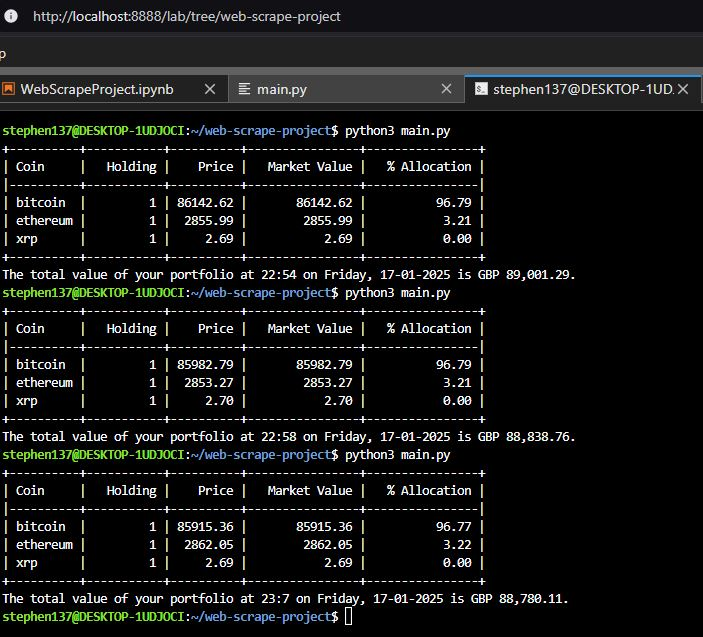



### Section 7. Afterthoughts and Improvements

Although I have created helper function and custom classes, the `main.py` script is still quite busy! Let's adopt a modular approach by creating separate `.py` files for the helper functions. This results in a much leaner `main.py` file.

`main.py`

In [ ]:
# Import required libraries
from price_fetcher import Coin, Position, Portfolio
from portfolio_val import display_portfolio_summary

if __name__ == "__main__":
    # Arbitrary user-selected portfolio
    bitcoin = Coin("bitcoin", "GBP")
    ethereum = Coin("ethereum", "GBP")
    xrp = Coin("xrp", "GBP")

    positions = [
        Position(bitcoin, 1),
        Position(ethereum, 1),
        Position(xrp, 1)
    ]

    portfolio = Portfolio(positions)
    display_portfolio_summary(portfolio)

### Introducing automation using `cron`

Now that we have a working portfolio valuation it would be useful to schedule the running of the report, say every day at 12:20pm. [Cron](https://docs.gitlab.com/ee/topics/cron/) syntax is used to schedule when jobs should run :

OK, so let's schedule our portfolio report to run every day at 12pm.  To schedule a Python script (main.py) to run daily at 12:05 PM using cron, follow these steps:

- Step 1: Confirm Python Path
  
Find the full path to the Python interpreter. Run the following command in your terminal:

    which python3
    
- Step 2: Confirm the Full Path to main.py
  
Use the pwd command in the directory containing main.py to get its full path: 

    pwd

- Step 3: Edit the Crontab
  
Open the crontab editor:

    crontab -e
- Step 4: Add the Cron Job
  
Add the following line to schedule your script:

    TZ=Europe/Warsaw 
    20 12  * * * /usr/bin/python3 /home/stephen137/web-scrape-project/main.py >> /home/stephen137/web-scrape-project/logs/portfolio_val.log 2>&1
` /home/stephen137/web-scrape-project/logs/portfolio_val.lo` apppends standard output to portfolio_val.log\
` 2>&1` redirects any output error to the same file.


- Step 5: Save and Exit
  
Save the crontab file (in most editors, press CTRL+O to save and CTRL+X to exit)
- Step 6: Verify the Cron Job
  
Check the list of scheduled cron jobs to confirm the job is added:

    crontab -l   





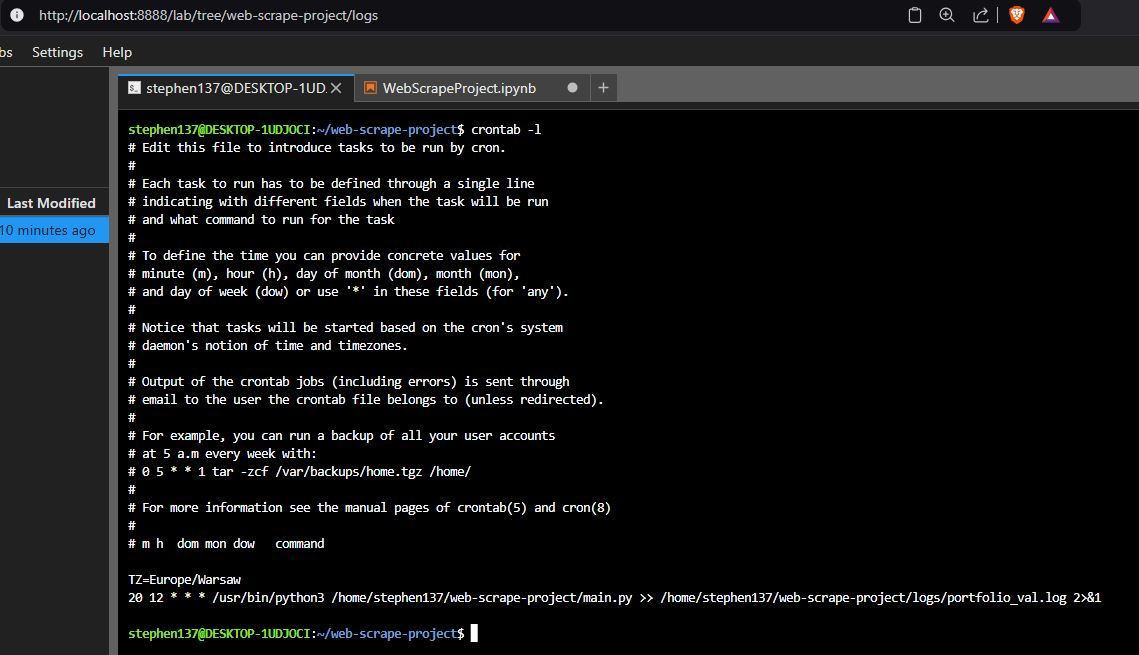

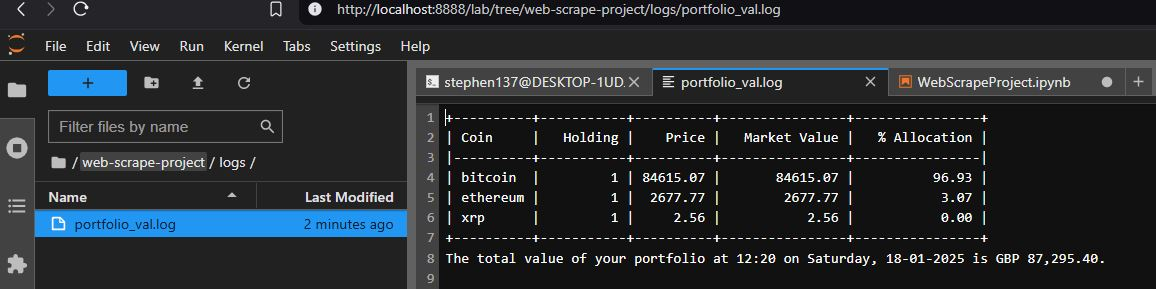

It worked. Powerful stuff. So now we have a daily portfolio valuation which could be emailed to the client.